In [4]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

Import Libraries

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.signal as signal
import pandas as pd
from sklearn.decomposition import PCA
import math
import warnings
warnings.filterwarnings('ignore')

## Questions
- what is "<Initial Activity>" as an activity name?

## Load & Explore Data

### Download and save the 'exercise_data.50.0000_singleonly.mat' file from the below link and save it locally in the same folder as this notebook file. 

https://msropendata.com/datasets/799c1167-2c8f-44c4-929c-227bf04e2b9a

In [2]:
# Load exercise dataset 
exercise_dataset = scipy.io.loadmat('exercise_data.50.0000_singleonly.mat', struct_as_record=False)

# Load activities and data full objects
exercise_constants = exercise_dataset['exerciseConstants'][0][0].activities
subject_data = exercise_dataset['subject_data']

# extract activities names into an array
all_activities = []
for act in exercise_constants[0]:
    all_activities.append(act[0])
    #print (act[0]) # print values for reference



In [3]:
# write all_activities to a file
all_activities

['<Initial Activity>',
 'Arm Band Adjustment',
 'Arm straight up',
 'Band Pull-Down Row',
 'Bicep Curl',
 'Biceps Curl (band)',
 'Box Jump (on bench)',
 'Burpee',
 'Butterfly Sit-up',
 'Chest Press (rack)',
 'Crunch',
 'Device on Table',
 'Dip',
 'Dumbbell Deadlift Row',
 'Dumbbell Row (knee on bench) (label spans both arms)',
 'Dumbbell Row (knee on bench) (left arm)',
 'Dumbbell Row (knee on bench) (right arm)',
 'Dumbbell Squat (hands at side)',
 'Dynamic Stretch (at your own pace)',
 'Elliptical machine',
 'Fast Alternating Punches',
 'Invalid',
 'Jump Rope',
 'Jumping Jacks',
 'Kettlebell Swing',
 'Lateral Raise',
 'Lawnmower (label spans both arms)',
 'Lawnmower (left arm)',
 'Lawnmower (right arm)',
 'Lunge (alternating both legs, weight optional)',
 'Medicine Ball Slam',
 'Non-Exercise',
 'Note',
 'Overhead Triceps Extension',
 'Overhead Triceps Extension (label spans both arms)',
 'Plank',
 'Power Boat pose',
 'Pushup (knee or foot variation)',
 'Pushups',
 'Repetitive Stretch

In [36]:
# only take data from 3 random exercises
activities_to_process = random.choices(all_activities, k=3)
print(activities_to_process)

['Squat', 'Side Plank Left side', 'Triceps Kickback (knee on bench) (left arm)']


In [37]:
# define dictionaries for accelerometer and gyroscope data
activities_accelerometer_data_dict = { activities_to_process[0]: [], activities_to_process[1]: [], activities_to_process[2]: []}
activities_gyroscope_data_dict = { activities_to_process[0]: [], activities_to_process[1]: [], activities_to_process[2]: []}
rep_counts_actual = []

# iterate over subject data to search for those activities and save the data related
for data_item in subject_data:
    for x in data_item:
        if len(x) > 0:
            if x[0] is not None and len(x[0]) > 0:
                data_activity_name = x[0,0].activityName[0]
                data_activity_reps = x[0,0].activityReps[0]
                data_item_accelDataMatrix = x[0,0].data[0,0].accelDataMatrix
                data_item_gyroDataMatrix = x[0,0].data[0,0].gyroDataMatrix
                if data_activity_name in activities_to_process:
                    activities_accelerometer_data_dict[data_activity_name].append(data_item_accelDataMatrix)
                    activities_gyroscope_data_dict[data_activity_name].append(data_item_gyroDataMatrix)
                    rep_counts_actual.append(data_activity_reps)

In [38]:
data_item_accelDataMatrix.shape

(2551, 4)

In [39]:
data_item_gyroDataMatrix.shape

(2551, 4)

#### Deeper look at files
Below cells are just to see what fields are in the matlab files. Turning them into dictionaries gives a better view of the mat_struct objects

In [40]:
for x in exercise_dataset:
    print (x)

__header__
__version__
__globals__
subject_data
exerciseConstants
Fs


In [41]:
type(exercise_dataset['exerciseConstants'][0][0])

scipy.io.matlab._mio5_params.mat_struct

In [4]:
def loadmat(filename):
    '''
    this function should be called instead of direct scipy.io.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

exercise_dataset2 = loadmat('exercise_data.50.0000_singleonly.mat')
exercise_dataset2

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct  9 09:47:27 2018',
 '__version__': '1.0',
 '__globals__': [],
 'subject_data': array([[array([], dtype=uint8),
         array([], dtype=float64), ...,
         array([<scipy.io.matlab._mio5_params.mat_struct object at 0x7f87562f4d30>,
               dtype=object)                                                        ,
         array([<scipy.io.matlab._mio5_params.mat_struct object at 0x7f875631c7f0>,
               dtype=object)                                                        ,
         array([], dtype=float64)],
        [array([], dtype=uint8), array([], dtype=float64),
         array([<scipy.io.matlab._mio5_params.mat_struct object at 0x7f87d099ff10>,
               dtype=object)                                                        ,
         ..., array([], dtype=float64), array([], dtype=float64),
         array([], dtype=float64)],
        [array([], dtype=uint8), array([], dtype=float64),
      

In [5]:
exercise_dataset2['exerciseConstants'].keys()

dict_keys(['activities', 'usefulActivityGroupings'])

In [6]:
exercise_dataset2['subject_data'].shape

(94, 75)

In [24]:
def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

# exercise_dataset2['subject_data'][0][3][0]
subject_id = 0
activity_index = 3
set_index = 0
_todict(exercise_dataset2['subject_data'][subject_id][activity_index][set_index])

# activityReps = ground truth for reps
# activityName = ground truth for name of activity/exercise


/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/2144290944.py:8: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):


{'masterFileToken': 'rightArm',
 'fileIndex': 110,
 'subjectIndex': 1,
 'activityIndex': 1,
 'instanceIndex': 1,
 'activityName': 'Band Pull-Down Row',
 'boundingWindow': array([674.099, 721.868, 674.099, 721.868]),
 'instanceIndexInSourceFile': 1,
 'sampleRate': 50,
 'incompleteData': 0,
 'activityStartMatrix': array([], dtype=object),
 'subjectID': 3,
 'recordingID': 735181.5970717593,
 'masterToken': 'rightArm',
 'data': {'accelDataMatrix': array([[ 6.74115498e+02,  1.27625993e-01, -6.81292868e-01,
          -1.46254786e-01],
         [ 6.74135498e+02,  7.27224014e-02, -4.68179817e-01,
           6.38812751e-04],
         [ 6.74155498e+02,  4.42798020e-02, -4.17980159e-01,
           1.30540401e-01],
         ...,
         [ 7.21815180e+02,  8.38230483e-01, -3.98169313e-01,
           4.72936805e-01],
         [ 7.21835180e+02,  7.04328927e-01, -3.45491330e-01,
           3.76540130e-01],
         [ 7.21855179e+02,  5.53215997e-01, -2.70578519e-01,
           4.48454272e-01]]),
  'g

### EDA

In [44]:
print(len(all_activities))

75


In [45]:
activities_accelerometer_data_dict[activities_to_process[0]][1].shape

(2576, 4)

Below, we see that each recorded activity set has a varying duration.

In [46]:
for activity in activities_to_process:
    print("Activity: " + activity)
    print("Accelerometer data shape: " + str(len(activities_accelerometer_data_dict[activity])))
    print("Gyroscope data shape: " + str(len(activities_gyroscope_data_dict[activity])))
    print("")
    for i in activities_accelerometer_data_dict[activity]:
        print(activity + "accelerometer data_ray_shape: " + str(i.shape))
    for i in activities_accelerometer_data_dict[activity]:
        print(activity + "gyroscope data_ray_shape: " + str(i.shape))

Activity: Squat
Accelerometer data shape: 25
Gyroscope data shape: 25

Squataccelerometer data_ray_shape: (3112, 4)
Squataccelerometer data_ray_shape: (2576, 4)
Squataccelerometer data_ray_shape: (3409, 4)
Squataccelerometer data_ray_shape: (3649, 4)
Squataccelerometer data_ray_shape: (4021, 4)
Squataccelerometer data_ray_shape: (3294, 4)
Squataccelerometer data_ray_shape: (4141, 4)
Squataccelerometer data_ray_shape: (2344, 4)
Squataccelerometer data_ray_shape: (3115, 4)
Squataccelerometer data_ray_shape: (2122, 4)
Squataccelerometer data_ray_shape: (5671, 4)
Squataccelerometer data_ray_shape: (2492, 4)
Squataccelerometer data_ray_shape: (2802, 4)
Squataccelerometer data_ray_shape: (2913, 4)
Squataccelerometer data_ray_shape: (1908, 4)
Squataccelerometer data_ray_shape: (3063, 4)
Squataccelerometer data_ray_shape: (2601, 4)
Squataccelerometer data_ray_shape: (2384, 4)
Squataccelerometer data_ray_shape: (2875, 4)
Squataccelerometer data_ray_shape: (1695, 4)
Squataccelerometer data_ray_s

### Visualizations

#### Accelerometer Measurements chart (only the first result of exercises per activity has been taken)

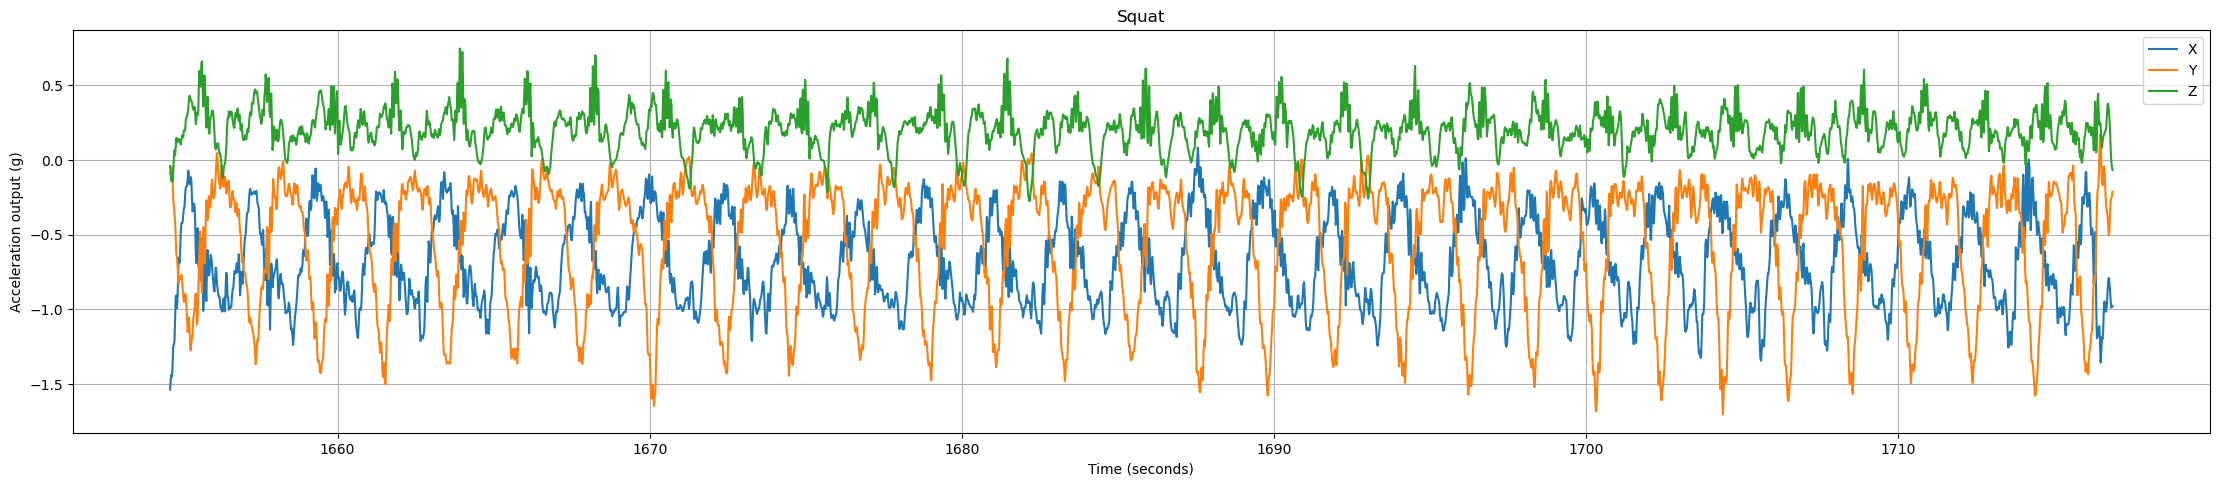

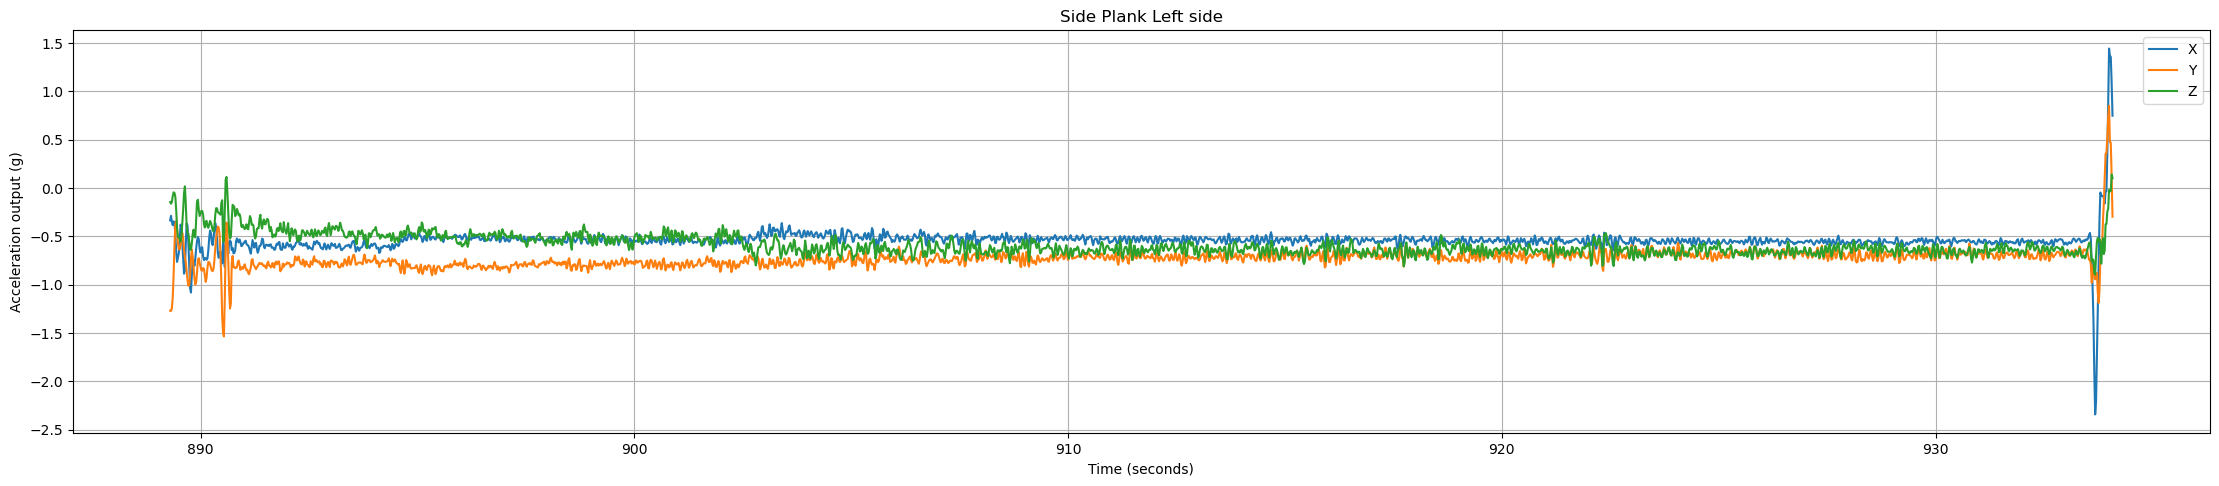

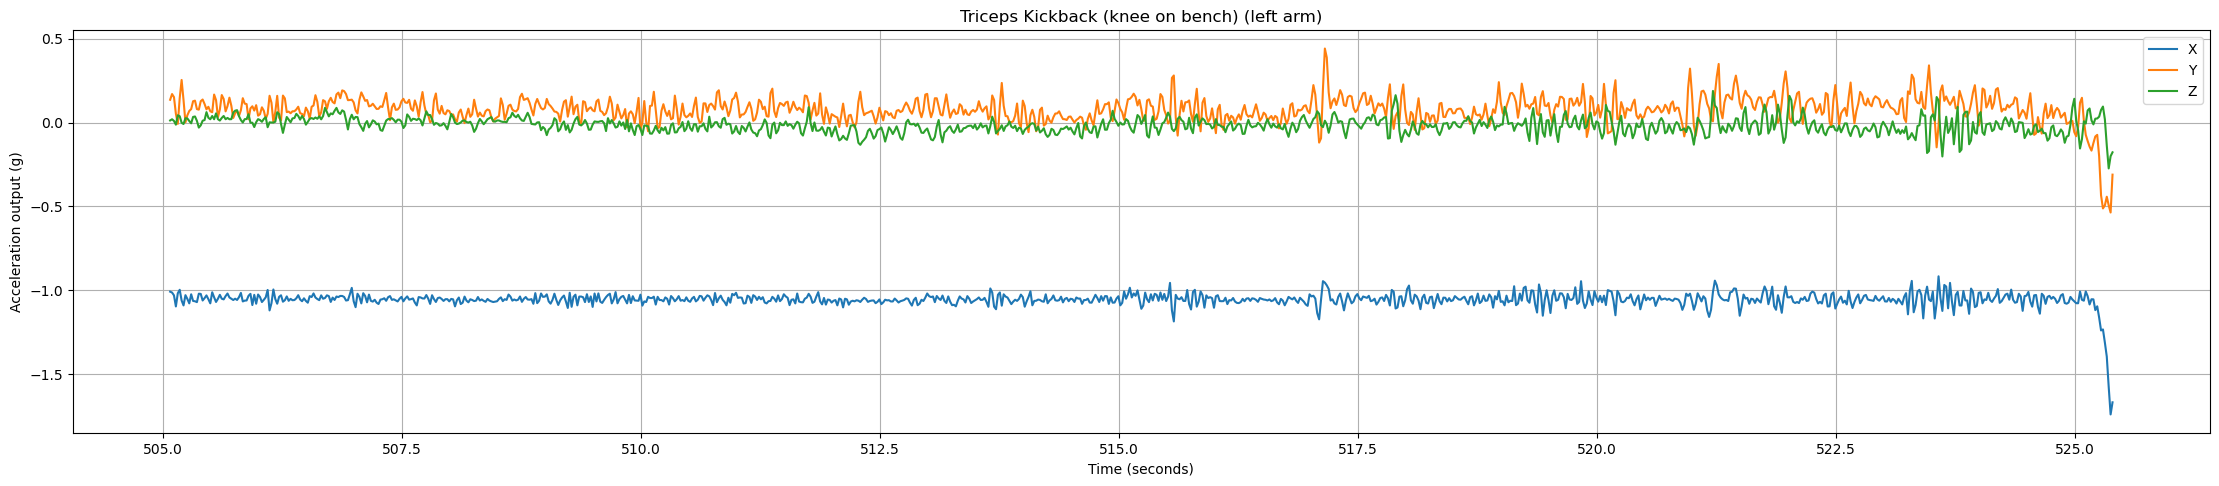

In [47]:
# Data to graph
for activity in activities_to_process:
       t, x, y, z = [], [], [], []

       for data_activity in activities_accelerometer_data_dict[activity][0]: # take only the values corresponding to the results of the first excersise
              t.append(data_activity[0]) # time value
              x.append(data_activity[1]) # X value
              y.append(data_activity[2]) # Y value
              z.append(data_activity[3]) # Z value

       fig, ax = plt.subplots()
       ax.plot(t, x, label = 'X')
       ax.plot(t, y, label = 'Y')
       ax.plot(t, z, label = 'Z')

       ax.set(xlabel='Time (seconds)', ylabel='Acceleration output (g)', title=activity)
       ax.grid()

       fig.tight_layout()
       fig.set_size_inches(25, 5)

       plt.legend()
       plt.show()

#### Gyroscope Measurements chart (only the first result of exercises per activity has been taken)

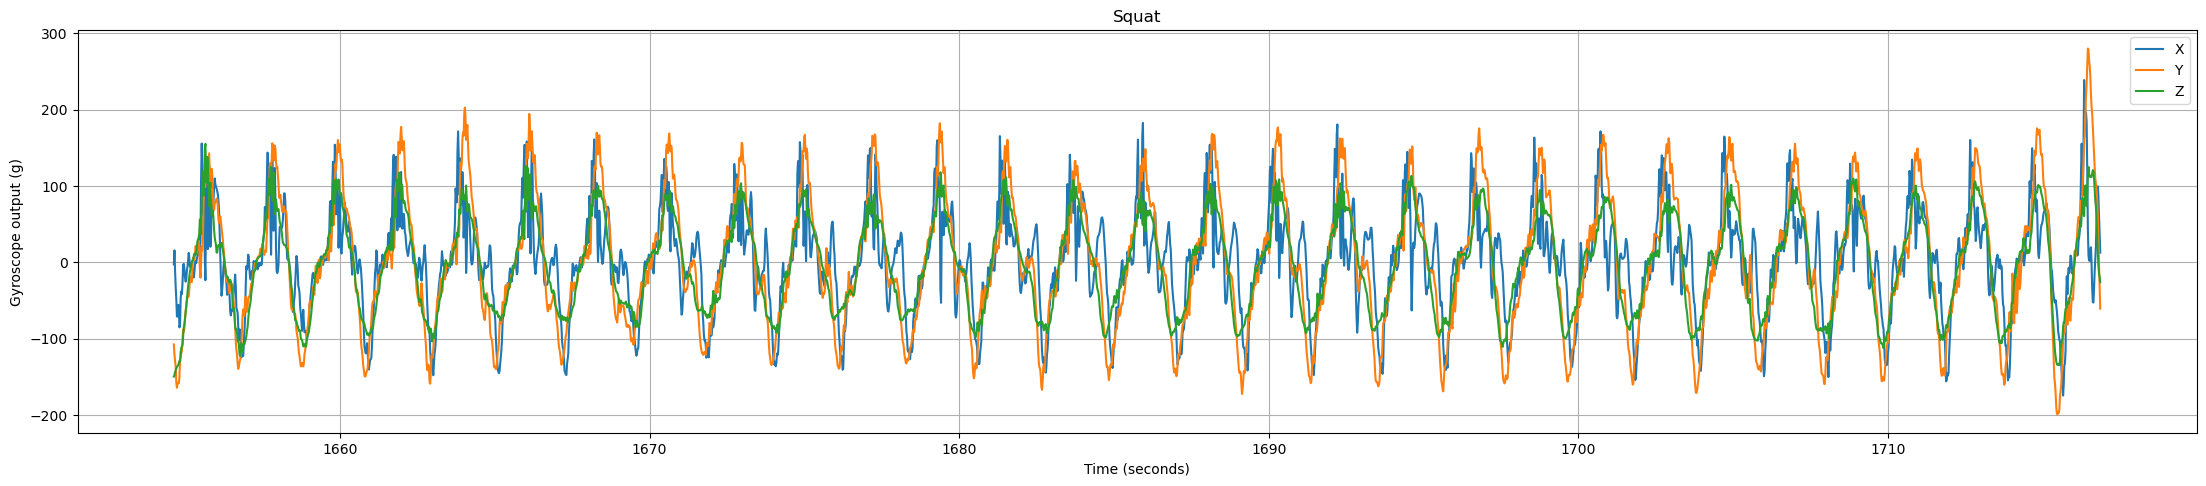

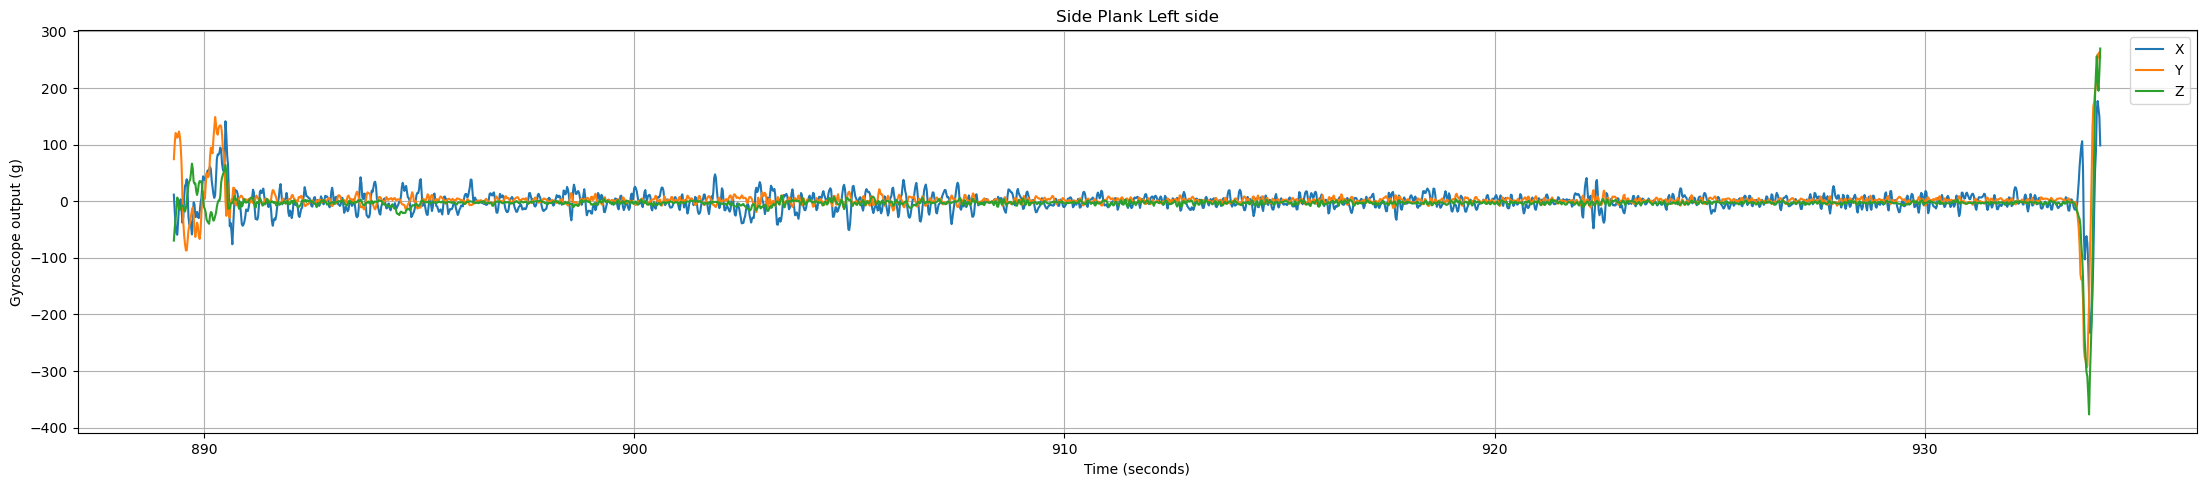

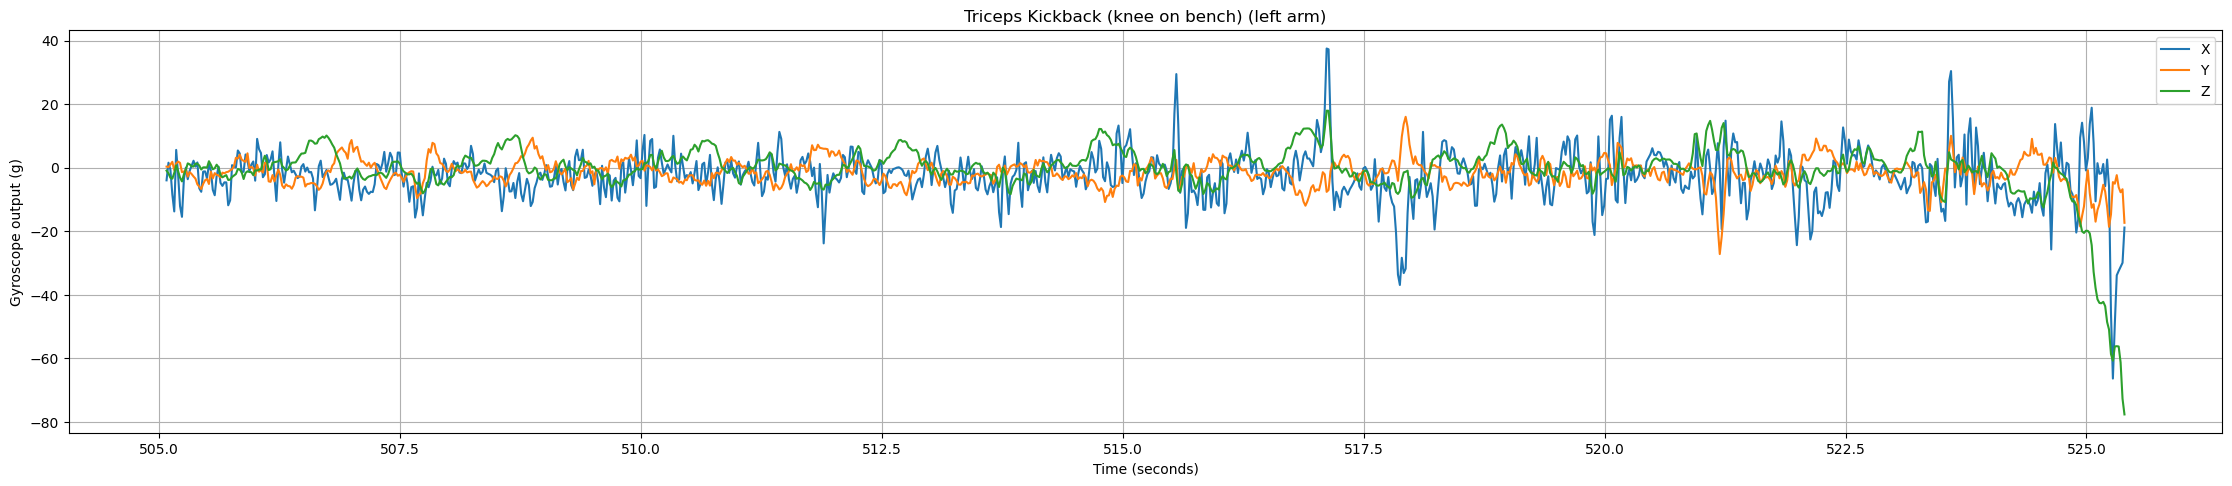

In [48]:
# Data to graph
for activity in activities_to_process:
       t, x, y, z = [], [], [], []

       for data_activity in activities_gyroscope_data_dict[activity][0]: # take only the values corresponding to the results of the first excersise
              t.append(data_activity[0]) # time value
              x.append(data_activity[1]) # X value
              y.append(data_activity[2]) # Y value
              z.append(data_activity[3]) # Z value

       fig, ax = plt.subplots()
       ax.plot(t, x, label = 'X')
       ax.plot(t, y, label = 'Y')
       ax.plot(t, z, label = 'Z')

       ax.set(xlabel='Time (seconds)', ylabel='Gyroscope output (g)', title=activity)
       ax.grid()

       fig.tight_layout()
       fig.set_size_inches(25, 5)

       plt.legend()
       plt.show()

## Segmentation Pre-Processing
Given data points containing x,y,z, and time, how would you smooth this data with a Butterworth low-pass filter (-60dB at 20Hz), then windowed into 5-second windows sliding at 200ms (i.e., each 5s window shares 4.8s of data with the previous window)

In [49]:
def apply_butterworth_lowpass(data, sampling_rate, cutoff_frequency, filter_order):
    nyquist_frequency = 0.5 * sampling_rate  # Updated line
    normalized_cutoff_frequency = cutoff_frequency / nyquist_frequency
    b, a = signal.butter(filter_order, normalized_cutoff_frequency, btype='low', analog=False, output='ba')
    smoothed_data = signal.lfilter(b, a, data)
    return smoothed_data

# Initialize a dictionary windowed_smoothed_data with keys as activities_to_process and corresponding values as empty lists
windowed_smoothed_data = {activity: [] for activity in activities_to_process}

# Assuming 'x', 'y', 'z', and 'time' are your data arrays in seconds
N = 4  # Filter order
sampling_rate = 1.0  # Sampling rate of 1 Hz
cutoff_frequency = 0.2  # Cutoff frequency of 0.2 Hz
filter_order = N  # Specify the desired filter order

# create embeddings
def preprocess(data_source, source_name):
    window_size = 250 # Window size of 5 seconds = 250 points
    cols = ['x', 'y', 'z', 't']
    cols_expanded = ([col + str(i) for col in cols for i in range(window_size)])
    windowed_smoothed_data_table = {col: [] for col in cols_expanded}
    windowed_smoothed_data_table['activity'] = []
    windowed_smoothed_data_table['set_num'] = []

    for activity in activities_to_process:
        for set_num, data_activity_set in enumerate(data_source[activity]):
            # Create empty arrays to store the windowed data
            windowed_x = []
            windowed_y = []
            windowed_z = []
            windowed_t = []

            t = data_activity_set[:,0]
            x = data_activity_set[:,1]
            y = data_activity_set[:,2]
            z = data_activity_set[:,3]

            # Normalize the data arrays to be less than abs(1)
            max_value = max(max(x), max(y), max(z), max(t))
            x_normalized = [value / max_value for value in x]
            y_normalized = [value / max_value for value in y]
            z_normalized = [value / max_value for value in z]

            # Apply the Butterworth filter (reduces noise)
            smoothed_x = apply_butterworth_lowpass(x_normalized, sampling_rate, cutoff_frequency, filter_order)
            smoothed_y = apply_butterworth_lowpass(y_normalized, sampling_rate, cutoff_frequency, filter_order)
            smoothed_z = apply_butterworth_lowpass(z_normalized, sampling_rate, cutoff_frequency, filter_order)

            # Slide the window over the smoothed data 
            overlap = 1 # Overlap of 4.8 seconds
            windowed_x = np.array([smoothed_x[i:i+window_size] for i in range(0, len(smoothed_x) - window_size + 1, overlap)])
            windowed_y = np.array([smoothed_y[i:i+window_size] for i in range(0, len(smoothed_y) - window_size + 1, overlap)])
            windowed_z = np.array([smoothed_z[i:i+window_size] for i in range(0, len(smoothed_z) - window_size + 1, overlap)])
            windowed_t = np.array([t[i:i+window_size] for i in range(0, len(t) - window_size + 1, overlap)])

            # The windowed_x, windowed_y, and windowed_z arrays now contain the windowed data
            window_row_count = windowed_x.shape[0]
            windowed_smoothed_data_table['activity'].extend([activity] * window_row_count)
            windowed_smoothed_data_table['set_num'].extend([set_num] * window_row_count)
            windowed_vals = [windowed_x, windowed_y, windowed_z, windowed_t]
            for c, col in enumerate(cols):
                for i in range(window_size):
                    windowed_smoothed_data_table[col+str(i)].extend(windowed_vals[c][:,i])
                    
    
    assert(len(windowed_smoothed_data_table['x0']) == len(windowed_smoothed_data_table['y0']) == len(windowed_smoothed_data_table['z0']) == len(windowed_smoothed_data_table['t0']))
    df = pd.DataFrame(windowed_smoothed_data_table)
    df['source'] = source_name
    return df


In [50]:
df_gyroscope = preprocess(activities_gyroscope_data_dict, 'gyroscope')
df_accelerometer = preprocess(activities_accelerometer_data_dict, 'accelerometer')

In [52]:
assert(len([col for col in df_gyroscope.columns if col.startswith('x')]) 
    == len([col for col in df_gyroscope.columns if col.startswith('y')]) 
    == len([col for col in df_gyroscope.columns if col.startswith('z')]) 
    == len([col for col in df_gyroscope.columns if col.startswith('t')]))
print("number of time points in each window ", len([col for col in df_gyroscope.columns if col.startswith('t')]))

number of time points in each window  250


In [53]:
assert(df_accelerometer['set_num'].max() == (len(df_gyroscope['set_num'].unique())-1))
# add a column called rep_counts_actual to df_accelerometer where the value for that set_num corresponds to the index in rep_counts_actual 
df_accelerometer['rep_counts_actual'] = df_accelerometer['set_num'].apply(lambda x: rep_counts_actual[x])
df_gyroscope['rep_counts_actual'] = df_gyroscope['set_num'].apply(lambda x: rep_counts_actual[x])


In [51]:
df_gyroscope.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135559 entries, 0 to 135558
Columns: 1003 entries, x0 to source
dtypes: float64(1000), int64(1), object(2)
memory usage: 1.0+ GB


In [54]:
# set the source, set_num, and activity columns as the index
df_gyroscope.set_index(['source', 'set_num', 'activity'], inplace=True)

## Segmentation Feature Computation
1) aX: the X-axis accelerometer signal

2) aXmag: the magnitude of the accelerometer signal at each sample, i.e. sqrt(ax2+ay2+az2).

3) aPC1: the projection of the three-dimensional accelerometer signal onto its first principal component. This is the movement along the axis that demonstrates the most variance within this window, or – anecdotally – themost “interesting” rotation of the window.

4) aYZPC1: the projection of only the Y and Z axes onto the first principal component of those two axes. This captures movement perpendicular to the arm, which allows us to derive information from the Y and Z axes despite the unknown rotation of the armband. 

In [55]:
def get_pc1(df):
    # perform PCA on each row of df with all columns that start with 'x' or 'y' or 'z'
    dim_cols = [col for col in df.columns if col.startswith('x') or col.startswith('y') or col.startswith('z') or col.startswith('t')]
    window = df[dim_cols].iloc[0]
    pc1 = []

    for w in range(len(df)):
        #for w in range(10):
        window = df[dim_cols].iloc[w]
        window_df = {}
        ts = list(window[[col for col in window.index if col.startswith('t')]].values)
        xs = list(window[[col for col in window.index if col.startswith('x')]].values)
        ys = list(window[[col for col in window.index if col.startswith('y')]].values)
        zs = list(window[[col for col in window.index if col.startswith('z')]].values)

        window_df = {'t': ts, 'x': xs, 'y': ys, 'z': zs}
        window_df = pd.DataFrame(window_df)
        window_df.set_index('t', inplace=True)

        # Perform PCA on the data
        pca = PCA(n_components=1) # only keep the first principal component
        principal_components = pca.fit_transform(window_df)
        pc1.append(principal_components[:, 0])
    assert(len(pc1) == len(df))
    return pc1

In [56]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def get_pc1(df):
    dim_cols = [col for col in df.columns if col.startswith('x') or col.startswith('y') or col.startswith('z') or col.startswith('t')]
    window = df[dim_cols].iloc[0]

    ts_cols = [col for col in window.index if col.startswith('t')]
    xyz_cols = [col for col in window.index if col.startswith('x') or col.startswith('y') or col.startswith('z')]

    window_df = pd.DataFrame(index=window[ts_cols].values, columns=['x', 'y', 'z'])

    pc1 = []

    for _, row in df[dim_cols].iterrows():
        window_df['x'] = row[xyz_cols[:len(ts_cols)]].values
        window_df['y'] = row[xyz_cols[len(ts_cols):2*len(ts_cols)]].values
        window_df['z'] = row[xyz_cols[2*len(ts_cols):]].values

        pca = PCA(n_components=1)
        principal_components = pca.fit_transform(window_df.values)
        pc1.append(principal_components[0, 0])

    assert len(pc1) == len(df)
    return pc1


In [57]:
# calculate percentage of nan in each column of df_gyroscope where percentage is greater than 0
nan_percentage = df_gyroscope.isna().sum() / len(df_gyroscope)
nan_percentage[nan_percentage > 0]


Series([], dtype: float64)

In [86]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from joblib import Parallel, delayed

def calculate_pca(window):
    window_df = {}
    ts = list(window[[col for col in window.index if col.startswith('t')]].values)
    xs = list(window[[col for col in window.index if col.startswith('x')]].values)
    ys = list(window[[col for col in window.index if col.startswith('y')]].values)
    zs = list(window[[col for col in window.index if col.startswith('z')]].values)

    window_df = {'t': ts, 'x': xs, 'y': ys, 'z': zs}
    window_df = pd.DataFrame(window_df)
    window_df.set_index('t', inplace=True)

    pca = PCA(n_components=1)
    principal_components = pca.fit_transform(window_df)
    return principal_components

def get_pc1(df):
    dim_cols = [col for col in df.columns if col.startswith('x') or col.startswith('y') or col.startswith('z') or col.startswith('t')]
    pc1 = Parallel(n_jobs=-1)(delayed(calculate_pca)(row[dim_cols]) for w, row in df.iterrows())
    assert len(pc1) == len(df)
    return pc1

def add_pc_cols(df, pc, pc_name):
    # create columns for every index of pc[0] in df 
    for i in range(len(pc[0])):
        df[pc_name+'_'+str(i)] = [pc[j][i] for j in range(len(pc))]
    assert(len([col for col in df.columns if col.startswith(pc_name)]) == len(pc[0]))

In [72]:
pc1 = get_pc1(df_gyroscope)

250

135559
135559


In [81]:
print(len(pc1[0]))
print(len(df_gyroscope))
print(len(pc1))

add_pc_cols(df_gyroscope, pc1, 'pc1')

/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/2222560660.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gyroscope['pc1_'+str(i)] = [pc1[j][i] for j in range(len(pc1))]
/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/2222560660.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gyroscope['pc1_'+str(i)] = [pc1[j][i] for j in range(len(pc1))]
/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/2222560660.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is u

In [83]:
pc1 = get_pc1(df_accelerometer)
print(len(pc1[0]))
print(len(df_accelerometer))
print(len(pc1))

add_pc_cols(df_accelerometer, pc1, 'pc1')


250
135559
135559


NameError: name 'add_pc_cols' is not defined

In [88]:
# to do delete this version of the function as it's too slow
def get_pc2(df):
    # perform PCA on df.iloc[0] columns that start with 'x' or 'y' or 'z'
    dim_cols = [col for col in df.columns if col.startswith('x') or col.startswith('y') or col.startswith('z') or col.startswith('t')]
    pc2 = []
    for w in range(len(df)):
        window = df[dim_cols].iloc[w]
        window_df = {}
        ts = list(window[[col for col in window.index if col.startswith('t')]].values)
        ys = list(window[[col for col in window.index if col.startswith('y')]].values)
        zs = list(window[[col for col in window.index if col.startswith('z')]].values)

        window_df = {'t': ts, 'y': ys, 'z': zs}
        window_df = pd.DataFrame(window_df)
        window_df.set_index('t', inplace=True)

        # Perform PCA on the data
        pca = PCA(n_components=1)  # Set the number of components to 2
        principal_components = pca.fit_transform(window_df)

        # Create new columns for aPC1 and aPC2 in the DataFrame
        pc2.append(principal_components[:, 0])

    assert(len(pc2) == len(df))
    return pc2


In [89]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from joblib import Parallel, delayed

def calculate_pcayz(window):
    window_df = {}
    ts = list(window[[col for col in window.index if col.startswith('t')]].values)
    ys = list(window[[col for col in window.index if col.startswith('y')]].values)
    zs = list(window[[col for col in window.index if col.startswith('z')]].values)

    window_df = {'t': ts, 'y': ys, 'z': zs}
    window_df = pd.DataFrame(window_df)
    window_df.set_index('t', inplace=True)

    pca = PCA(n_components=1)
    principal_components = pca.fit_transform(window_df)
    return principal_components

def get_pc2(df):
    dim_cols = [col for col in df.columns if col.startswith('y') or col.startswith('z') or col.startswith('t')]
    pc1 = Parallel(n_jobs=-1)(delayed(calculate_pcayz)(row[dim_cols]) for w, row in df.iterrows())
    assert len(pc1) == len(df)
    return pc1


In [90]:
yzpc = get_pc2(df_gyroscope)
print(len(yzpc[0]))
print(len(df_gyroscope))
print(len(yzpc))

add_pc_cols(df_gyroscope, yzpc, 'yzpc')

250
135559
135559


/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/1120434693.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[pc_name+'_'+str(i)] = [pc[j][i] for j in range(len(pc))]
/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/1120434693.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[pc_name+'_'+str(i)] = [pc[j][i] for j in range(len(pc))]
/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/1120434693.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

In [91]:
yzpc = get_pc2(df_accelerometer)
print(len(yzpc[0]))
print(len(df_accelerometer))
print(len(yzpc))

add_pc_cols(df_accelerometer, yzpc, 'yzpc')

250
135559
135559


/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/1120434693.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[pc_name+'_'+str(i)] = [pc[j][i] for j in range(len(pc))]
/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/1120434693.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[pc_name+'_'+str(i)] = [pc[j][i] for j in range(len(pc))]
/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/1120434693.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

In [105]:
# create embeddings
def get_raw_x(data_source):
    window_size = 250 # Window size of 5 seconds = 250 points
    temp_dict = { 'x_'+str(i): [] for i in range(window_size) }

    for activity in activities_to_process:
        for set_num, data_activity_set in enumerate(data_source[activity]):
            x = data_activity_set[:,1]
            overlap = 1 # Overlap of 4.8 seconds
            windowed_x = np.array([x[i:i+window_size] for i in range(0, len(x) - window_size + 1, overlap)])
            window_row_count = windowed_x.shape[0]
            
            for i in range(len(windowed_x[0])):
                temp_dict['x_'+str(i)].extend([windowed_x[j][i] for j in range(len(windowed_x))])
    return temp_dict


In [106]:
gyroscope_x = get_raw_x(activities_gyroscope_data_dict)
accelerometer_x = get_raw_x(activities_accelerometer_data_dict)
assert(len(gyroscope_x['x_0']) == len(df_gyroscope))

In [113]:
# add the raw x columns to df_gyroscope
for i in range(len(gyroscope_x.keys())):
    df_gyroscope['x_'+str(i)] = gyroscope_x['x_'+str(i)]
    df_accelerometer['x_'+str(i)] = accelerometer_x['x_'+str(i)]
assert(len(gyroscope_x.keys()) == len([col for col in df_gyroscope.columns if col.startswith('x_')]))

/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/1633512546.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gyroscope['x_'+str(i)] = gyroscope_x['x_'+str(i)]
/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/1633512546.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_accelerometer['x_'+str(i)] = accelerometer_x['x_'+str(i)]
/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/1633512546.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

In [118]:
len(df_accelerometer.columns) == len(df_gyroscope.columns)
print(len(df_accelerometer.columns))

1754


In [117]:
print(len(df_gyroscope.columns))

1751


In [119]:
[col for col in df_accelerometer.columns if col not in df_gyroscope.columns]

['activity', 'set_num', 'source']

In [120]:
# make df_gyroscope index into columns
df_gyroscope.reset_index(inplace=True)
assert(len(df_accelerometer.columns) == len(df_gyroscope.columns))

In [124]:
# TODO: should square root here instead of later
for i in range(250):
    df_gyroscope['xmag'+str(i)] = df_gyroscope['x'+str(i)]**2 + df_gyroscope['y'+str(i)]**2 + df_gyroscope['z'+str(i)]**2

/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/3983393490.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gyroscope['gxmag'+str(i)] = df_gyroscope['x'+str(i)]**2 + df_gyroscope['y'+str(i)]**2 + df_gyroscope['z'+str(i)]**2
/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/3983393490.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gyroscope['gxmag'+str(i)] = df_gyroscope['x'+str(i)]**2 + df_gyroscope['y'+str(i)]**2 + df_gyroscope['z'+str(i)]**2
/var/folders/tn/2c791sdx0cx4t8_bxzn028mm

In [127]:
# TODO: should square root here instead of later
for i in range(250):
    df_accelerometer['axmag'+str(i)] = df_accelerometer['x'+str(i)]**2 + df_accelerometer['y'+str(i)]**2 + df_accelerometer['z'+str(i)]**2

/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/1160797519.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_accelerometer['axmag'+str(i)] = df_accelerometer['x'+str(i)]**2 + df_accelerometer['y'+str(i)]**2 + df_accelerometer['z'+str(i)]**2
/var/folders/tn/2c791sdx0cx4t8_bxzn028mm0000gn/T/ipykernel_37801/1160797519.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_accelerometer['axmag'+str(i)] = df_accelerometer['x'+str(i)]**2 + df_accelerometer['y'+str(i)]**2 + df_accelerometer['z'+str(i)]**2
/var/fol

In [134]:
print(df_gyroscope.columns)

Index(['g_source', 'g_set_num', 'g_activity', 'g_x0', 'g_x1', 'g_x2', 'g_x3',
       'g_x4', 'g_x5', 'g_x6',
       ...
       'g_gxmag240', 'g_gxmag241', 'g_gxmag242', 'g_gxmag243', 'g_gxmag244',
       'g_gxmag245', 'g_gxmag246', 'g_gxmag247', 'g_gxmag248', 'g_gxmag249'],
      dtype='object', length=2254)


In [136]:
print(df_accelerometer.columns)

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       ...
       'axmag240', 'axmag241', 'axmag242', 'axmag243', 'axmag244', 'axmag245',
       'axmag246', 'axmag247', 'axmag248', 'axmag249'],
      dtype='object', length=2004)


In [146]:
# write all column names to file
with open('gyroscope_column_names.txt', 'w') as f:
    for col in df_gyroscope.columns:
        f.write(col + '\n')

with open('accelerometer_column_names.txt', 'w') as f:
    for col in df_accelerometer.columns:
        f.write(col + '\n')


In [152]:
print(len(df_gyroscope.columns))
print(len(df_accelerometer.columns))
assert(len(df_accelerometer.columns) == len(df_gyroscope.columns))

2003
2003


In [157]:
df_gyroscope.columns = [col[2:] if col.endswith('source') 
    or col.endswith('set_num') or col.endswith('activity') or col.endswith('rep_counts_actual')
    else col for col in df_gyroscope.columns]
df_accelerometer.columns = [col[2:] if col.endswith('source') 
    or col.endswith('set_num') or col.endswith('activity') or col.endswith('rep_counts_actual')
    else col for col in df_gyroscope.columns]

In [163]:
mutual_cols = [col for col in df_gyroscope.columns if col.startswith('t')]
mutual_cols.extend(['rep_counts_actual'])
len(mutual_cols)

251

In [159]:
df_gyroscope.to_pickle('df_gyroscope0611.pkl')
df_accelerometer.to_pickle('df_accelerometer0611.pkl')

In [166]:
# join accelerometer and gyroscope dataframes on index
df = df_gyroscope.join(df_accelerometer, how='inner', lsuffix='_gyroscope', rsuffix='_accelerometer')
assert(len(df_gyroscope) == len(df) == len(df_accelerometer))

In [167]:
df.head()

,set_num,activity,g_x0_gyroscope,g_x1_gyroscope,g_x2_gyroscope,g_x3_gyroscope,g_x4_gyroscope,g_x5_gyroscope,g_x6_gyroscope,g_x7_gyroscope,...,g_gxmag240_accelerometer,g_gxmag241_accelerometer,g_gxmag242_accelerometer,g_gxmag243_accelerometer,g_gxmag244_accelerometer,g_gxmag245_accelerometer,g_gxmag246_accelerometer,g_gxmag247_accelerometer,g_gxmag248_accelerometer,g_gxmag249_accelerometer
0,0,Squat,-0.000075,0.000067,0.001045,0.000884,-0.005106,-0.017762,-0.031731,-0.040670,...,7.218217e-07,7.211887e-07,7.424479e-07,7.682473e-07,7.628724e-07,7.239683e-07,6.760769e-07,6.259035e-07,5.623487e-07,4.946061e-07
1,0,Squat,0.000067,0.001045,0.000884,-0.005106,-0.017762,-0.031731,-0.040670,-0.041493,...,7.211887e-07,7.424479e-07,7.682473e-07,7.628724e-07,7.239683e-07,6.760769e-07,6.259035e-07,5.623487e-07,4.946061e-07,4.515509e-07
2,0,Squat,0.001045,0.000884,-0.005106,-0.017762,-0.031731,-0.040670,-0.041493,-0.037196,...,7.424479e-07,7.682473e-07,7.628724e-07,7.239683e-07,6.760769e-07,6.259035e-07,5.623487e-07,4.946061e-07,4.515509e-07,4.354064e-07
3,0,Squat,0.000884,-0.005106,-0.017762,-0.031731,-0.040670,-0.041493,-0.037196,-0.035967,...,7.682473e-07,7.628724e-07,7.239683e-07,6.760769e-07,6.259035e-07,5.623487e-07,4.946061e-07,4.515509e-07,4.354064e-07,4.121039e-07
4,0,Squat,-0.005106,-0.017762,-0.031731,-0.040670,-0.041493,-0.037196,-0.035967,-0.040838,...,7.628724e-07,7.239683e-07,6.760769e-07,6.259035e-07,5.623487e-07,4.946061e-07,4.515509e-07,4.354064e-07,4.121039e-07,3.614607e-07


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135559 entries, 0 to 135558
Columns: 4006 entries, set_num to g_gxmag249_accelerometer
dtypes: float64(3000), int64(2), object(1004)
memory usage: 4.0+ GB


In [169]:
# TODO: should've done this earlier
# for column name that contains "xmag" in df, replace value with the square root
for col in df.columns:
    if col.startswith('g_gxmag') or col.startswith('a_axmag'):
        df[col] = df[col].apply(lambda x: math.sqrt(x))

In [1]:
df.to_pickle("mergeddf_0611.pkl")

NameError: name 'df' is not defined